# Fruits-360 dataset

A base de dados aqui utilizada já vem padronizada e tratada, portanto seguimos com o pré-processamento a ser realizado abaixo.

## Carregamento e Vizualização

In [19]:
import os
import numpy as np
import cv2
from PIL import Image
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve, validation_curve
from sklearn.svm import SVC
import umap.umap_ as umap
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, roc_curve, auc, confusion_matrix
import seaborn as sns
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import pickle
from collections import Counter

In [20]:
dataset_path = "fruits_dataset/fruits-test"
IMAGE_SIZE = (100, 100)
BATCH_SIZE = 500  # Treino em lotes
DATA_AUGMENTATION = True

# def visualize_samples(path, num_samples=5):
#     sample_path = os.path.join(path, "Banana 1")
#     sample_images = os.listdir(sample_path)[:num_samples]
#     for img in sample_images:
#         image = Image.open(os.path.join(sample_path, img))
#         plt.imshow(image)
#         plt.axis('off')
#         plt.show()

# visualize_samples(dataset_path)

## Pré-processamento das Imagens

In [ ]:
# Criar gerador de imagens para Data Augmentation
data_gen = ImageDataGenerator(
    rotation_range=15, width_shift_range=0.1, height_shift_range=0.1,
    shear_range=0.1, zoom_range=0.1, horizontal_flip=True
)

def load_images_and_labels(dataset_path):
    X, y = [], []
    label_encoder = LabelEncoder()
    
    fruit_dirs = os.listdir(dataset_path)
    label_encoder.fit(fruit_dirs)
    
    for fruit_dir in fruit_dirs:
        fruit_path = os.path.join(dataset_path, fruit_dir)
        img_files = os.listdir(fruit_path)
        
        for img_file in img_files:
            img_path = os.path.join(fruit_path, img_file)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Erro ao carregar imagem: {img_path}")
                continue
            img = cv2.resize(img, IMAGE_SIZE)
            img = img.astype(np.float32) / 255.0  # Normalização [0,1]
            X.append(img.flatten())  # Vetorização
            y.append(fruit_dir)
    
    return np.array(X), label_encoder.transform(y), label_encoder

# Carregar imagens e rótulos
X, y, label_encoder = load_images_and_labels(dataset_path)

# Dividir dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Aplicar Data Augmentation apenas no conjunto de treino
if DATA_AUGMENTATION:
    X_train_augmented, y_train_augmented = [], []
    X_train_reshaped = X_train.reshape(-1, 100, 100, 3)
    
    # Gerar novas imagens até atingir o número desejado
    aug_batches = data_gen.flow(X_train_reshaped, y_train, batch_size=BATCH_SIZE, shuffle=False)

    for i in range(len(X_train) // BATCH_SIZE):  # Gera apenas a quantidade correta de amostras
        X_batch, y_batch = next(aug_batches)
        X_train_augmented.extend(X_batch.reshape(X_batch.shape[0], -1))
        y_train_augmented.extend(y_batch)
    
    X_train_augmented = np.array(X_train_augmented)
    y_train_augmented = np.array(y_train_augmented)

    # Certificar que o número de amostras bate antes de concatenar
    min_samples = min(len(X_train_augmented), len(y_train))
    X_train = np.vstack((X_train, X_train_augmented[:min_samples]))
    y_train = np.hstack((y_train, y_train_augmented[:min_samples]))

# Normalização
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reduzir dimensionalidade com UMAP
umap_reducer = umap.UMAP(n_components=50, random_state=42)
X_train_umap = umap_reducer.fit_transform(X_train, y_train)  
X_test_umap = umap_reducer.transform(X_test)

c:\Users\hagaf\OneDrive\Desktop\Projetos-GitHub\RP-RN-2024.2\env\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


## Classificação de Padrões

Distribuição de Classes: Counter({5: 984, 3: 936, 0: 656, 1: 656, 4: 656, 6: 656, 2: 600})


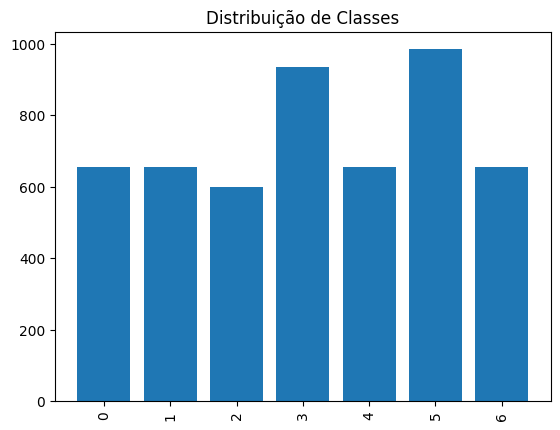

In [23]:
from collections import Counter
class_distribution = Counter(y)
print("Distribuição de Classes:", class_distribution)
sorted_classes = sorted(class_distribution.keys())
plt.bar(sorted_classes, [class_distribution[c] for c in sorted_classes])
plt.xticks(rotation=90)
plt.title("Distribuição de Classes")
plt.show()

In [24]:
# Classificação usando SVM
param_grid = {
    'C': [0.1], 
    'kernel': ['rbf'], # ['linear', 'poly', 'rbf', 'sigmoid']
    # 'degree': [2, 3, 4], # if 'poly'
    'gamma': [100] # ['scale', 'auto', 0.001, 0.01, 0.1, 1]
}

grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_train_umap, y_train)
best_svm = grid_search.best_estimator_
svm_predictions = best_svm.predict(X_test_umap)

## Regressão de Funções e Avaliação

In [25]:
# Avaliação do SVM
print("SVM Classification Report:")
print(classification_report(y_test, svm_predictions))
print("SVM Accuracy:", accuracy_score(y_test, svm_predictions))

# Validação cruzada com SVM
svm_cv_scores = cross_val_score(best_svm, X_train_umap, y_train, cv=5)
print("SVM Cross-validation Accuracy:", svm_cv_scores.mean())

SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.32      0.49       131
           1       1.00      0.23      0.37       131
           2       1.00      0.15      0.26       120
           3       1.00      0.79      0.88       188
           4       1.00      0.20      0.33       131
           5       0.27      1.00      0.42       197
           6       1.00      0.25      0.40       131

    accuracy                           0.48      1029
   macro avg       0.90      0.42      0.45      1029
weighted avg       0.86      0.48      0.48      1029

SVM Accuracy: 0.48104956268221577
SVM Cross-validation Accuracy: 0.26173752310536047


In [26]:
# # Análise de variância se scores seguem uma distribuição normal e têm variâncias similares (ANOVA)
# f_stat, p_value = f_oneway(svm_cv_scores, knn_cv_scores, rf_cv_scores)
# print("ANOVA F-Statistic:", f_stat)
# print("ANOVA P-Value:", p_value)

# if p_value < 0.05:
#     print("Rejeitamos a hipótese nula: há diferenças estatisticamente significativas entre os modelos.")
# else:
#     print("Não rejeitamos a hipótese nula: não há evidências de diferenças significativas entre os modelos.")

# # Análise de variância para valores se scores não seguem uma distribuição normal (Kruskal-Wallis)
# from scipy.stats import kruskal

# h_stat, p_value = kruskal(svm_cv_scores, knn_cv_scores, rf_cv_scores)
# print("Kruskal-Wallis H-Statistic:", h_stat)
# print("Kruskal-Wallis P-Value:", p_value)

# if p_value < 0.05:
#     print("Rejeitamos a hipótese nula: há diferenças estatisticamente significativas entre os modelos.")
# else:
#     print("Não rejeitamos a hipótese nula: não há evidências de diferenças significativas entre os modelos.")

In [27]:
print("SVM Train Accuracy:", best_svm.score(X_train_umap, y_train))
print("SVM Test Accuracy:", accuracy_score(y_test, svm_predictions))

SVM Train Accuracy: 0.5385089340727048
SVM Test Accuracy: 0.48104956268221577


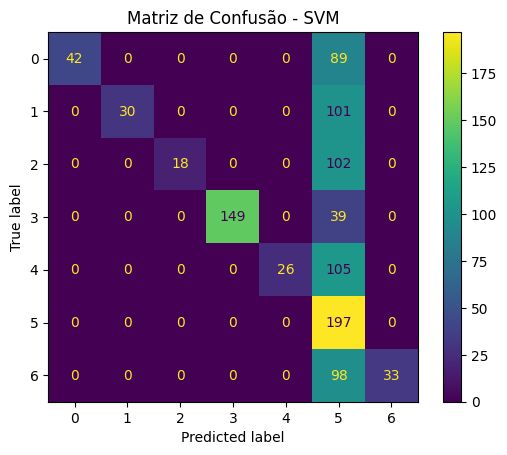

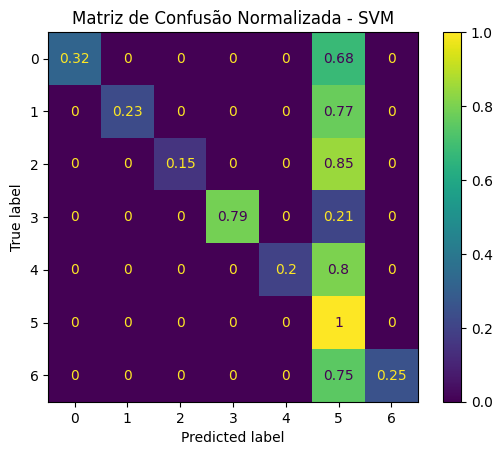

In [28]:
ConfusionMatrixDisplay.from_estimator(best_svm, X_test_umap, y_test)
plt.title("Matriz de Confusão - SVM")
plt.show()

ConfusionMatrixDisplay.from_estimator(best_svm, X_test_umap, y_test, normalize='true')
plt.title("Matriz de Confusão Normalizada - SVM")
plt.show()

In [ ]:
# Função para plotar a curva ROC para cada classe
def plot_multiclass_roc(y_test_bin, y_score, model_name):
    plt.figure()
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Classe {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Linha de referência
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Curva ROC - {model_name}')
    plt.legend(loc='lower right')
    plt.show()

# Binarizar rótulos (One-hot encoding)
n_classes = len(np.unique(y_test))  # Número de classes únicas
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))  # Torna (901,) -> (901, n_classes)

# Probabilidades preditas pelos modelos
y_score_svm = best_svm.decision_function(X_test_umap)  # Saída do SVM

# Plotar curvas ROC para cada modelo
plot_multiclass_roc(y_test_bin, y_score_svm, "SVM")

In [ ]:
def plot_error_2d(errors, title):
    plt.scatter(errors[:, 0], errors[:, 1], color='red', label='Erros')
    plt.title(title)
    plt.xlabel("Componente Principal 1")
    plt.ylabel("Componente Principal 2")
    plt.legend()
    plt.show()

# Encontrar amostras mal classificadas corretamente
errors_svm = X_test_umap[np.where(y_test != svm_predictions)]

# Plotar os erros para cada modelo
plot_error_2d(errors_svm, "Distribuição de Erros - SVM")

In [ ]:
def plot_learning_curve(train_sizes, train_mean, test_mean, title):
    plt.plot(train_sizes, train_mean, label='Treinamento', color='blue')
    plt.plot(train_sizes, test_mean, label='Validação', color='orange')
    plt.xlabel('Tamanho do Conjunto de Treinamento')
    plt.ylabel('Score')
    plt.title(title)
    plt.legend()
    plt.show()

train_sizes_svm, train_scores_svm, test_scores_svm = learning_curve(best_svm, X_train_umap, y_train, cv=5)
train_mean_svm = train_scores_svm.mean(axis=1)
test_mean_svm = test_scores_svm.mean(axis=1)
plot_learning_curve(train_sizes_svm, train_mean_svm, test_mean_svm, "Curva de Aprendizado - SVM")

In [ ]:
def plot_validation_curve(param_range, train_mean, test_mean, title):
    plt.plot(param_range, train_mean, label='Treinamento', color='blue')
    plt.plot(param_range, test_mean, label='Validação', color='orange')
    plt.xlabel('Parâmetro C')
    plt.ylabel('Score')
    plt.title(title)
    plt.legend()
    plt.show()

param_range = [0.1, 1, 10, 100]

train_scores_vc_svm, test_scores_vc_svm = validation_curve(SVC(), X_train_umap, y_train, param_name="C", param_range=param_range, cv=5)
train_mean_vc_svm = train_scores_vc_svm.mean(axis=1)
test_mean_vc_svm = test_scores_vc_svm.mean(axis=1)
plot_validation_curve(param_range, train_mean_vc_svm, test_mean_vc_svm, "Curva de Validação - SVM")

In [ ]:
def plot_confusion_matrix(cm):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Matriz de Confusão - Heatmap")
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.show()

cm_svm = confusion_matrix(y_test, svm_predictions)

plot_confusion_matrix(cm_svm)

## Salvando os Resultados

In [ ]:
# # Salva características para uso posterior
# with open("features.pkl", "wb") as f:
#     pickle.dump((features_batch, labels_batch), f)